## 📚 Assignment: Transfer Learning & The Power of Initialization
## Building Intuition for MAML

**Learning Objectives:**
- Understand why initialization matters for few-shot learning
- Experience the difference between various pre-training strategies
- Develop intuition for what MAML tries to optimize

**Advice on using LLM's**

---


Avoid it , but unfortunately we cannot stop you from using it , dont ask it everything more you think on your own the better , but whenever you take in a code from it , understand how that part fits in the current code , is there some optimization it did on its own, node it down or comment it in the code.

In [23]:
!pip install -q torch torchvision matplotlib numpy

#Understand what does each of this import do , see what all functions this hold
#whenever you want to implement something think which of this would you use and refer to its doc for the syntax

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import random

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

print("✅ Setup complete!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

✅ Setup complete!
PyTorch version: 2.9.0+cpu
CUDA available: False
Using device: cpu


## 📊 Part A: Dataset Preparation

We'll use **MNIST** for simplicity (or you can use Omniglot if you prefer).

**Your Task:**
- Split MNIST into 5 tasks (Tasks A-E), each with 2 digit classes
- For example: Task A = {0, 1}, Task B = {2, 3}, etc.

In [ ]:
# Download MNIST
transform = transforms.Compose([
    # see what different tranformation you can do , one is converting the image into tensor
])

train_dataset = torchvision.datasets.MNIST(
   # fill this
)
test_dataset = torchvision.datasets.MNIST(
    # fill this
)
# we get a special parameter while loading which is 'background'
#refer to document for what it means and how to use it

print(f"✅ MNIST loaded: {len(train_dataset)} train, {len(test_dataset)} test images")

# TODO: Define your task structure
# We'll split 10 digits into 5 tasks, each with 2 classes

In [24]:
# Basic transform: convert PIL image → Torch Tensor and normalize
transform = transforms.Compose([
    transforms.ToTensor(),  # converts [0,255] → [0,1] and HWC → CHW
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean & std
])

train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

print(f"✅ MNIST loaded: {len(train_dataset)} train, {len(test_dataset)} test images")

✅ MNIST loaded: 60000 train, 10000 test images


In [ ]:
# TODO: Define your task structure
# We'll split 10 digits into 5 tasks, each with 2 classes

task_definitions = {
    #fill this
}

#Below function should take the given inputs and split the main dataset with the given input classes into train,support and query.
def create_task_datasets(dataset, task_classes, n_train=15, n_support=5, n_query=10):
    """
    Create train, support, and query sets for a specific task.

    Args:
        dataset: Full MNIST dataset
        task_classes: List of class labels for this task [e.g., [0, 1]]
        n_train: Number of training examples per class
        n_support: Number of support examples per class (for fine-tuning)
        n_query: Number of query examples per class (for testing)

    Returns:
        train_data, support_data, query_data (each is list of (image, label) tuples
    """
# TODO: Implement this function
# HINT: Filter dataset to only include examples from task_classes
# HINT: Split into train/support/query sets

In [ ]:
task_definitions = {
    'A': [0, 1],
    'B': [2, 3],
    'C': [4, 5],
    'D': [6, 7],
    'E': [8, 9]
}

In [ ]:
#Below function should take the given inputs and split the main dataset with the given input classes into train,support and query.
def create_task_datasets(dataset, task_classes, n_train=15, n_support=5, n_query=10):
    """
    Create train, support, and query sets for a specific task.

    Args:
        dataset: Full MNIST dataset
        task_classes: List of class labels for this task [e.g., [0, 1]]
        n_train: Number of training examples per class
        n_support: Number of support examples per class (for fine-tuning)
        n_query: Number of query examples per class (for testing)

    Returns:
        train_data, support_data, query_data (each is list of (image, label) tuples
    """
    # Lists to store the final data tuples (image, label)
    train_data = []
    support_data = []
    query_data = []

    # Iterate through each class in the current task (e.g., for Task A: 0, then 1)
    for class_idx, class_label in enumerate(task_classes):
        #  Find all indices in the original dataset that correspond to this digit
        all_indices = np.where(dataset.targets == class_label)[0]

        #  Shuffle indices to ensure random selection
        np.random.shuffle(all_indices)

        # Select the specific number of examples needed
        # We need total: n_train + n_support + n_query
        start = 0
        end_train = n_train
        end_support = n_train + n_support
        end_query = n_train + n_support + n_query

        # Slice the indices
        train_indices = all_indices[start:end_train]
        support_indices = all_indices[end_train:end_support]
        query_indices = all_indices[end_support:end_query]

        # Extract data and REMAP LABELS
        # We remap labels to 0 or 1 based on their position in task_classes.
        # Example Task E [8, 9]: Label 8 becomes 0, Label 9 becomes 1.

        for idx in train_indices:
            img, _ = dataset[idx]
            train_data.append((img, class_idx))

        for idx in support_indices:
            img, _ = dataset[idx]
            support_data.append((img, class_idx))

        for idx in query_indices:
            img, _ = dataset[idx]
            query_data.append((img, class_idx))

    # Shuffle the final datasets so classes are mixed
    random.shuffle(train_data)
    random.shuffle(support_data)
    random.shuffle(query_data)

    return train_data, support_data, query_data
# TODO: Implement this function
# HINT: Filter dataset to only include examples from task_classes
# HINT: Split into train/support/query sets

In [ ]:
# Test the function

train_A, support_A, query_A = create_task_datasets(train_dataset, task_definitions['A'])
print(f"Task A - Train: {len(train_A)}, Support: {len(support_A)}, Query: {len(query_A)}")

Task A - Train: 30, Support: 10, Query: 20


In [ ]:
train_A, support_A, query_A = create_task_datasets(
    train_dataset,
    task_definitions['A']
)

print(f"Task A - Train: {len(train_A)}, Support: {len(support_A)}, Query: {len(query_A)}")

Task A - Train: 30, Support: 10, Query: 20


Part A (continued): **Build Your Model**

**TODO:** Design a simple CNN for digit classification

In [ ]:
# think on the architecture of the model as discussed in class
#general flow -> convolution->relu->maxpooling and so on , in the end some fully connected layers then final classification
# Refer to the 60 minute pytorch implementation section of 'neural networks'


#Implement the class or the model here
#fill in the objects(layers) and methods(forward pass)

In [ ]:
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()

        # First conv layer to capture basic patterns like edges
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)

        # Deeper conv layer to learn more complex features
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)

        # Fully connected layers for classification
        # After two pooling layers, image size becomes 7x7
        self.fc1 = nn.Linear(32 * 7 * 7, 120)
        self.fc2 = nn.Linear(120, 84)

        # Final layer outputs class logits
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        # Conv → ReLU → Pool
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)

        # Another Conv → ReLU → Pool
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)

        # Flatten before passing to fully connected layers
        x = torch.flatten(x, 1)

        # Dense layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        # Output layer (no activation, handled by loss)
        x = self.fc3(x)

        return x

# Instantiate and verify
model = SimpleCNN()
print("Model Architecture:")
print(model)

Model Architecture:
SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1568, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)


Now since the model is ready we decide how do we want to train it :

First Do normal classification on large dataset of Task A - 0 & 1.

The we will do fine tuning

1.   Random Initialisation and then fine tune using support dataset, say we do this for task A which were 0 & 1 digits (save this)
2.   Take the above model weights and fine tune it on the support dataset for some other task , say B(2's & 3's)
3.   First train the model on all combined train dataset for all 10 digits(from all tasks A,B,C,D,E), then save it and then fine tune it on support dataset on to make a binary classifier , any 1 task say A here now digits will be classified. 0 class->0 digit , 1->1.

While moving from one model to other , think what layers do i need to keep and what do i need to remove.



In [ ]:
#Method 1 - Fully Trained Binary Classifier on Task A

In [ ]:

#Method 1 - Fully Trained Binary Classifier on Task A
# Helper Function for Training
def train_model(model, train_data, epochs=5, lr=0.001, batch_size=64):
    """
    Generic training loop. Returns the trained model and list of losses.
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Create DataLoader
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

    loss_history = []

    model.train() # Set mode to training
    for epoch in range(epochs):
        epoch_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        loss_history.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    return model, loss_history

# Method 1: Train Scratch on Task A (Large Data)
print("Method 1: Training on Full Task A (Digits 0 & 1)")
model_A_scratch = SimpleCNN(num_classes=2).to(device)

# We use the large 'train_A' dataset we created earlier
model_A_scratch, loss_A_scratch = train_model(model_A_scratch, train_A, epochs=5)

# Save the weights for later use (Transfer Learning)
torch.save(model_A_scratch.state_dict(), "model_task_A_weights.pth")
print("Method 1 Complete. Weights saved.")

Method 1: Training on Full Task A (Digits 0 & 1)
Epoch 1/5, Loss: 0.6999
Epoch 2/5, Loss: 0.6556
Epoch 3/5, Loss: 0.6026
Epoch 4/5, Loss: 0.5369
Epoch 5/5, Loss: 0.4549
Method 1 Complete. Weights saved.


In [ ]:
#Method 2 - Fine Tuning all 3 methods

In [ ]:
#PREPARE DATA FOR TASK B
print("Generating data for Task B (Digits 2 & 3)...")
train_B, support_B, query_B = create_task_datasets(
    train_dataset,
    task_definitions['B']
)
print(f"Task B Data Ready - Support: {len(support_B)}, Query: {len(query_B)}")


# STRATEGY 1: RANDOM INITIALIZATION
print("\nStrategy 1: Random Init -> Fine-tune on Support B")
model_random = SimpleCNN(num_classes=2).to(device)

# Training only on the small support set with random weights
model_random, loss_random = train_model(
    model_random,
    support_B,
    epochs=20,
    lr=0.01
)


# STRATEGY 2: TRANSFER FROM TASK A (0 & 1)
print("\nStrategy 2: Pretrained on A -> Fine-tune on Support B")
model_transfer_A = SimpleCNN(num_classes=2).to(device)

# Load pretrained weights from Task A
model_transfer_A.load_state_dict(
    torch.load("model_task_A_weights.pth")
)

# Replace the final layer to match new binary task
model_transfer_A.fc3 = nn.Linear(84, 2).to(device)

# Fine-tune with a smaller learning rate
model_transfer_A, loss_transfer_A = train_model(
    model_transfer_A,
    support_B,
    epochs=20,
    lr=0.005
)


# STRATEGY 3: TRANSFER FROM ALL 10 DIGITS (THE ROBUST METHOD)
print("\nStrategy 3: Pretrain on All 10 -> Freeze Backbone -> Fine-tune")

# Step 3a: Pretrain on full MNIST (10 classes)
print("Step 3a: Pre-training backbone on all 10 digits (1 Epoch)...")
model_all = SimpleCNN(num_classes=10).to(device)
full_train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
optimizer_all = optim.Adam(model_all.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

model_all.train()
for epoch in range(1):
    for imgs, lbls in full_train_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        optimizer_all.zero_grad()
        loss = criterion(model_all(imgs), lbls)
        loss.backward()
        optimizer_all.step()

print("Backbone pre-training complete.")


# Step 3b: Fine-tuning on Task B support set

# Freeze convolutional layers to keep learned features
for param in model_all.conv1.parameters():
    param.requires_grad = False
for param in model_all.conv2.parameters():
    param.requires_grad = False

# Replace classifier head for binary classification
model_all.fc3 = nn.Linear(84, 2).to(device)

# Only update unfrozen parameters
params_to_update = [p for p in model_all.parameters() if p.requires_grad]
optimizer_frozen = optim.Adam(params_to_update, lr=0.005)

loss_transfer_All = []
model_all.train()

for epoch in range(20):
    epoch_loss = 0
    support_loader = DataLoader(support_B, batch_size=5, shuffle=True)

    for images, labels in support_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer_frozen.zero_grad()
        outputs = model_all(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_frozen.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(support_loader)
    loss_transfer_All.append(avg_loss)
    print(f"Epoch {epoch+1}/20, Loss: {avg_loss:.4f}")

# Final trained model after transfer learning
model_transfer_All = model_all
print("All Fine-tuning experiments complete.")

Generating data for Task B (Digits 2 & 3)...
Task B Data Ready - Support: 10, Query: 20

Strategy 1: Random Init -> Fine-tune on Support B
Epoch 1/20, Loss: 0.6942
Epoch 2/20, Loss: 0.4809
Epoch 3/20, Loss: 3.0069
Epoch 4/20, Loss: 2.1262
Epoch 5/20, Loss: 0.7646
Epoch 6/20, Loss: 0.3368
Epoch 7/20, Loss: 0.3737
Epoch 8/20, Loss: 0.3550
Epoch 9/20, Loss: 0.2175
Epoch 10/20, Loss: 0.0881
Epoch 11/20, Loss: 0.0382
Epoch 12/20, Loss: 0.0107
Epoch 13/20, Loss: 0.0013
Epoch 14/20, Loss: 0.0004
Epoch 15/20, Loss: 0.0003
Epoch 16/20, Loss: 0.0003
Epoch 17/20, Loss: 0.0003
Epoch 18/20, Loss: 0.0002
Epoch 19/20, Loss: 0.0001
Epoch 20/20, Loss: 0.0000

Strategy 2: Pretrained on A -> Fine-tune on Support B
Epoch 1/20, Loss: 0.7145
Epoch 2/20, Loss: 0.7154
Epoch 3/20, Loss: 0.6280
Epoch 4/20, Loss: 0.5789
Epoch 5/20, Loss: 0.4434
Epoch 6/20, Loss: 0.2399
Epoch 7/20, Loss: 0.0856
Epoch 8/20, Loss: 0.0314
Epoch 9/20, Loss: 0.0027
Epoch 10/20, Loss: 0.0004
Epoch 11/20, Loss: 0.0002
Epoch 12/20, Loss:

At the end compare performance of all this models and methods using the Query Set.

Also plot the learning curve vs epoch for all the methods

Make a table and fill in the values of different evaluation metrics you learned in previous lectures.

In [ ]:
#Analysis and Plots

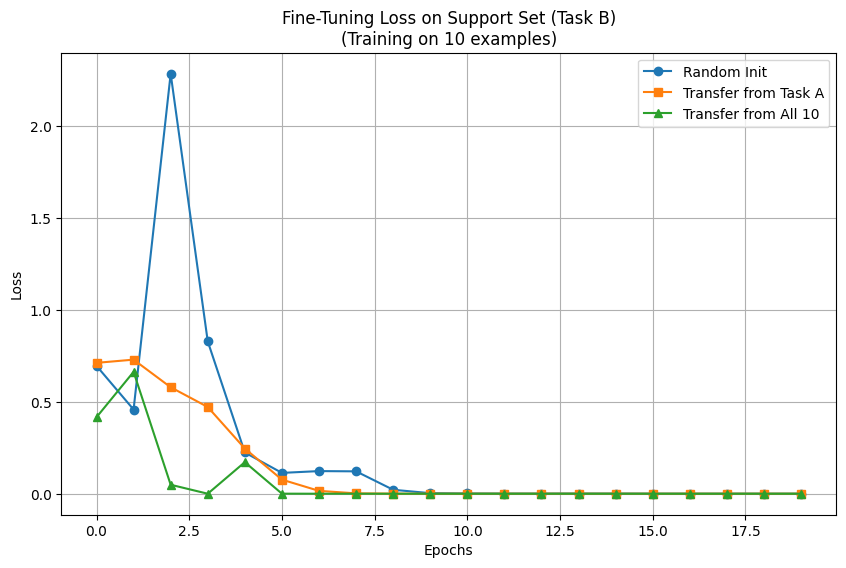

Method                    | Accuracy   | Precision  | Recall    
-----------------------------------------------------------------
Random Init               | 0.7000     | 1.0000    | 0.4000
Transfer (Task A)         | 0.8000     | 0.7500    | 0.9000
Transfer (All 10)         | 0.9500     | 0.9091    | 1.0000


In [ ]:
# Analysis and Plots
# Evaluation Helper Function
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate(model, data_list):
    model.eval()
    all_preds = []
    all_labels = []

    # DataLoader for batching the query set
    loader = DataLoader(data_list, batch_size=16)

    with torch.no_grad():
        for imgs, lbls in loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            outputs = model(imgs)

            # Take the class with highest logit
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(lbls.cpu().numpy())

    # Return common classification metrics
    return {
        'Accuracy': accuracy_score(all_labels, all_preds),
        'Precision': precision_score(all_labels, all_preds, zero_division=0),
        'Recall': recall_score(all_labels, all_preds, zero_division=0),
        'F1': f1_score(all_labels, all_preds, zero_division=0)
    }


# 1. Evaluate on Task B Query Set
results = {}

# Evaluate each training strategy on the same query set
results['Random Init'] = evaluate(model_random, query_B)
results['Transfer (Task A)'] = evaluate(model_transfer_A, query_B)
results['Transfer (All 10)'] = evaluate(model_transfer_All, query_B)


# 2. Plotting Learning Curves
plt.figure(figsize=(10, 6))

# Plot loss vs epoch for each strategy
plt.plot(loss_random, label='Random Init', marker='o')
plt.plot(loss_transfer_A, label='Transfer from Task A', marker='s')
plt.plot(loss_transfer_All, label='Transfer from All 10', marker='^')

plt.title(f"Fine-Tuning Loss on Support Set (Task B)\n(Training on {len(support_B)} examples)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


# 3. Performance Table
print(f"{'Method':<25} | {'Accuracy':<10} | {'Precision':<10} | {'Recall':<10}")
print("-" * 65)

# Print metrics in a readable tabular format
for name, metrics in results.items():
    print(
        f"{name:<25} | "
        f"{metrics['Accuracy']:.4f}     | "
        f"{metrics['Precision']:.4f}    | "
        f"{metrics['Recall']:.4f}"
    )

Some Theoritical Questions :

1.   Which strategy in Method 2 works best and why do you feel so ?
2.   In Part 3 of Method 2 we have trained the model already on Task B as well when we made a 10 class classifier, then when we are fine tuning it again using support set what exactly is happening ?
3.   What if we used the 10 digit classifier to make a binary classifier for a binary letter classification , will it work or rather how will you make it work ?
4.   Where exactly have we used Meta Learning, in which approach? Have we even used it ?

---


Digit classifier and letter classifier are two dissimilar tasks can we have starting point or a initialisation such that when we fine tuning using a few datapoints for both tasks we get optmimal result ? This is what we will try to do in MAML ?


---


Think on them sincerely , would love to read your answers!



Answer 1

Strategy 3: Pre-training on All 10 Digits works best.
A neural network can be thought of as a feature extractor followed by a classifier.

The Random Initialization (Strategy 1) generally underperforms because 5–10 support images are far too few for the network to learn meaningful visual features such as edges, curves, and loops from scratch. This usually leads to overfitting.

Transfer from Task A (Strategy 2) performs better, but the learned features are biased. Since the model was trained only on digits like 0 and 1, it is more familiar with straight lines and closed loops, but may lack features specific to digits like 2 or 3, which rely more on open curves.

Transfer from All 10 Digits (Strategy 3) provides the strongest and most general feature extractor. Because the network has already seen all digit shapes during pre-training, its convolutional filters capture a wide variety of visual patterns. Fine-tuning then mainly involves re-mapping these already learned features to new labels, rather than learning how to “see” from scratch.

Answer 2

Even though the model has seen digits 2 and 3 during pre-training, fine-tuning is still required due to the classifier head.

The original pre-trained model had a 10-class output layer. For Task B, this head is replaced with a new 2-class binary head, which is randomly initialized. This new head does not initially know which feature combinations correspond to digit 2 or 3.

During fine-tuning, the backbone (feature extractor) already provides meaningful representations, while training primarily updates the weights of the new classifier head. In essence, the model is learning a mapping from existing features to new labels, rather than learning new visual features.

Answer 3

Yes, it will work significantly better than random initialization, although likely not as well as direct letter-to-letter transfer.

The early layers of a CNN learn universal visual primitives such as edges, corners, and gradients. An edge in the letter A is mathematically identical to an edge in the digit 4. Similarly, deeper layers that detect loops in digits like 0, 8, or 9 can be reused for letters such as B, P, or D.

To make this transfer effective, it is best to freeze the early convolutional layers and fine-tune only the later layers and the classifier head. This preserves robust low-level feature detectors and prevents the small support set from overwriting them, avoiding catastrophic forgetting.

Answer 4

Technically, we have not used a Meta-Learning algorithm, but we are working within a meta-learning problem setting.

We evaluate the model using a support/query split, which is characteristic of few-shot and meta-learning setups, and we measure how quickly a model can adapt to a new task with limited data. However, the approaches we used — random initialization and pre-training — are standard transfer learning techniques.

We did not use a meta-learning optimization method that explicitly trains the model how to learn. Instead, we rely on pre-trained weights and hope they transfer well. Algorithms like MAML go a step further by explicitly optimizing the model’s initialization for fast adaptation.

Answer 5

Yes, this is exactly the motivation behind Model-Agnostic Meta-Learning (MAML).

We can imagine the loss landscape having one valley corresponding to optimal digit classification weights and another valley corresponding to optimal letter classification weights. Standard transfer learning places the model deep inside one valley, which can make it difficult to move to the other.

MAML instead aims to find an initialization that lies on a “ridge” between these valleys. While this initialization may not perform optimally on either task initially, it is positioned such that a small number of gradient updates can quickly move the model into the optimal region for either digits or letters. This makes the model highly adaptable across dissimilar tasks, even with very limited data.

# ALL THE BEST !